# LCS Player Makeup

## I browse the league of legends reddit a lot and a common complaint I see about the LCS is that many teams rely on imports instead of native talent. So for this analysis I wanted to see how many imports are present in each season starting with the most '21 Summer (since summer is generally the roster that organizations are banking on for the worlds spot)

In [67]:
# Import necessary libraries

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [68]:
master_df = pd.DataFrame(data=None)
master_df["Name"] = []
master_df["Role"] = []
master_df["Team"] = []
master_df["Region"] = []
master_df["Country"] = []
master_df["Year Season"] = []

In [69]:
urls = ["https://lol.fandom.com/wiki/LCS/2021_Season/Summer_Season/Team_Rosters", 
        "https://lol.fandom.com/wiki/LCS/2021_Season/Spring_Season/Team_Rosters",
        "https://lol.fandom.com/wiki/LCS/2020_Season/Summer_Season/Team_Rosters",
        "https://lol.fandom.com/wiki/LCS/2020_Season/Spring_Season/Team_Rosters",
        "https://lol.fandom.com/wiki/LCS/2019_Season/Summer_Season/Team_Rosters",
        "https://lol.fandom.com/wiki/LCS/2019_Season/Spring_Season/Team_Rosters",
        "https://lol.fandom.com/wiki/NA_LCS/2018_Season/Summer_Season/Team_Rosters",
        "https://lol.fandom.com/wiki/NA_LCS/2018_Season/Spring_Season/Team_Rosters",
        "https://lol.fandom.com/wiki/NA_LCS/2017_Season/Summer_Season/Team_Rosters",
        "https://lol.fandom.com/wiki/NA_LCS/2017_Season/Spring_Season/Team_Rosters",
        "https://lol.fandom.com/wiki/NA_LCS/2016_Season/Summer_Season/Team_Rosters",
        "https://lol.fandom.com/wiki/NA_LCS/2016_Season/Spring_Season/Team_Rosters",
        "https://lol.fandom.com/wiki/NA_LCS/2015_Season/Summer_Season/Team_Rosters",
        "https://lol.fandom.com/wiki/NA_LCS/2015_Season/Spring_Season/Team_Rosters",]

In [70]:
# Returns list of player rows (coaches included) from the respective lol liquipedia link

def get_player_rows(soup):
    return soup.find_all("tr", {"class": "multirow-highlighter"})

In [71]:
# Returns list of player regions (regions represent group of countries, imports count as not from NA region)

def get_player_regions(player_regions, player_rows):
    for player_row in player_rows:
        player_region = player_row.find("div", {"class": "region-icon"})
        if (player_region is not None):
            player_regions.append(player_region.text)
        else:
            player_regions.append("NaN")
    return player_regions

In [72]:
# Returns list of player countries (more specific than region, i.e. Germany is EU)

def get_player_countries(player_countries, player_rows):
    for player_row in player_rows:
        player_country = player_row.find("span", {"class": "sprite country-sprite"})
        if (player_country is not None):
            player_countries.append(player_country["title"])
        else:
            player_countries.append("NaN")
    return player_countries

In [73]:
# Returns list of player names

def get_player_names(player_names, player_rows):
    for player_row in player_rows:
        player_name = player_row.find("a", {"class": "catlink-players"})
        if (player_name is not None):
            player_names.append(player_name.text)
        else:
            player_names.append("NaN")
    return player_names

In [74]:
# Returns list of player roles

def get_player_roles(player_roles, player_rows):
    for player_row in player_rows:
        player_role = player_row.find("span", {"class": "role-sprite"})
        player_roles.append(player_role["title"])
    return player_roles

In [75]:
# Returns a list of the teams present that season (does not show too much variance once LCS was franchised)

def get_teams(teams, soup):
    team_names_html = soup.find_all("a", {"class": "catlink-teams"})
    for team_name in team_names_html:
        teams.append(team_name.text)
    return teams

In [76]:
# Returns a complete list of teams corresponding to players so can be attached to dataframe

def generate_player_teams(df, extended_teams_list, team_names):
    k = -1
    if ("Coach" in set(df["Role"])):
        for i, j in df.iterrows():
            if ((j["Role"] == "Top Laner") & (df.iloc[i-1]["Role"] == "Coach")):
                k += 1
            extended_teams_list.append(team_names[k])
        return extended_teams_list
    else:
        for i, j in df.iterrows():
            if ((j["Role"] == "Top Laner") & (df.iloc[i-1]["Role"] == "Support")):
                k += 1
            extended_teams_list.append(team_names[k])
        return extended_teams_list

In [77]:
# Get the year and the season and return combined string

def get_year_and_split(soup):
    title = soup.find("h1", {"class": "page-header__title"})
    year_starting_index = title.text.find("20")
    year = title.text[year_starting_index: year_starting_index+4]
    if (title.text.find("Summer") != -1):
        season_starting_index = title.text.find("Summer")
        season = title.text[season_starting_index: season_starting_index+6]
    else:
        season_starting_index = title.text.find("Spring")
        season = title.text[season_starting_index: season_starting_index+6]
    return year + " " + season

In [78]:
def generate_year_and_split_list(df, year):
    final_list = []
    for x in range(df.shape[0]):
        final_list.append(year)
        x += 1
    return final_list

In [79]:
for url in urls:
    
    url_page = requests.get(url)
    url_soup = BeautifulSoup(url_page.content, "html.parser")
    url_rows = get_player_rows(url_soup)
    
    names = []
    roles = []
    player_teams = []
    regions = []
    countries = []
    teams = []

    names = get_player_names(names, url_rows)
    roles = get_player_roles(roles, url_rows)
    regions = get_player_regions(regions, url_rows)
    countries = get_player_countries(countries, url_rows)
    teams = get_teams(teams, url_soup)
    season = get_year_and_split(url_soup)
    
    d = {'Name': names, 'Role': roles, 'Region': regions, 'Country': countries}
    df = pd.DataFrame(data=d)
    player_teams = generate_player_teams(df, player_teams, teams)
    df.insert(2, 'Team', player_teams)
    
    seasons = generate_year_and_split_list(df, season)
    
    df["Year Season"] = seasons
    
    master_df = pd.concat([master_df, df], sort=False)
    
master_df = master_df.replace("NaN", pd.NA)

master_df = master_df.dropna()

In [80]:
master_df_filtered = master_df[master_df["Role"] != "Coach"]

In [81]:
def get_pct_nat(df, season):
    season_df = master_df_filtered[master_df_filtered["Year Season"] == season]
    season_totl_p = season_df.shape[0]
    season_nat_p = season_df[(season_df["Region"] == "NA") | (season_df["Region"] == "OCE")].shape[0]
    season_nat_p_pct = round(season_nat_p / season_totl_p * 100, 2)
    return season_nat_p_pct

In [84]:
sum_21_nat_p_pct = get_pct_nat(master_df_filtered, "2021 Summer")

spg_21_nat_p_pct = get_pct_nat(master_df_filtered, "2021 Spring")

sum_20_nat_p_pct = get_pct_nat(master_df_filtered, "2020 Summer")

sum_20_nat_p_pct = get_pct_nat(master_df_filtered, "2020 Spring")

sum_19_nat_p_pct = get_pct_nat(master_df_filtered, "2019 Summer")

sum_19_nat_p_pct = get_pct_nat(master_df_filtered, "2019 Spring")

sum_18_nat_p_pct = get_pct_nat(master_df_filtered, "2018 Summer")

sum_18_nat_p_pct = get_pct_nat(master_df_filtered, "2018 Spring")

sum_17_nat_p_pct = get_pct_nat(master_df_filtered, "2017 Summer")

sum_17_nat_p_pct = get_pct_nat(master_df_filtered, "2017 Spring")

sum_16_nat_p_pct = get_pct_nat(master_df_filtered, "2016 Summer")

sum_16_nat_p_pct = get_pct_nat(master_df_filtered, "2016 Spring")

sum_15_nat_p_pct = get_pct_nat(master_df_filtered, "2015 Summer")

sum_15_nat_p_pct = get_pct_nat(master_df_filtered, "2015 Spring")

In [85]:
all_pct = {"Y": [spg_15_nat_p_pct, sum_15_nat_p_pct, spg_16_nat_p_pct, sum_16_nat_p_pct, spg_17_nat_p_pct, sum_17_nat_p_pct, 
                 spg_18_nat_p_pct, sum_18_nat_p_pct, spg_19_nat_p_pct, sum_19_nat_p_pct, spg_20_nat_p_pct, sum_20_nat_p_pct, 
                 spg_21_nat_p_pct, sum_21_nat_p_pct],
           "X": ["15 SPG", "15 SUM", "16 SPG", "16 SUM", "17 SPG", "17 SUM", "18 SPG", "18 SUM", "19 SPG", "19 SUM",
                 "20 SPG", "20 SUM", "21 SPG", "21 SUM"]}

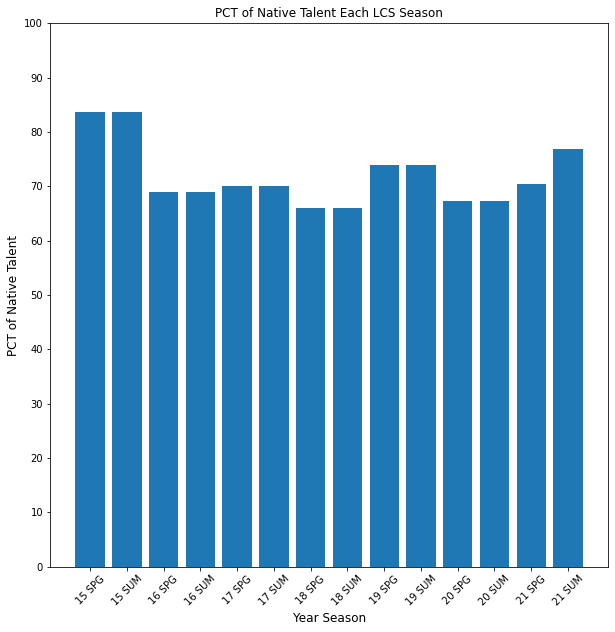

In [86]:
fig, ax = plt.subplots(figsize=(10,10));
ax.bar(all_pct["X"], all_pct["Y"],);
plt.xticks(rotation = 45);
ax.set_ylabel("PCT of Native Talent", fontdict={'size': 12});
ax.set_ylim(bottom=0.0, top=100.0)
ax.set_yticks(np.arange(0, 110, 10))
ax.set_xlabel("Year Season", fontdict={'size': 12});
ax.set_title("PCT of Native Talent Each LCS Season")
ax.tick_params(axis='both', which='major', labelsize=10)